2025-08-25 04:48:05,442 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-25 04:48:05,466 - INFO - Engineering lagged features...
2025-08-25 04:48:05,468 - INFO - Splitting test data at date: 2024-04-01
2025-08-25 04:48:05,470 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-25 04:48:05,473 - INFO - Starting hyperparameter search over 3024 combinations...
2025-08-25 04:48:05,891 - INFO - ✓ Valid model found: PICP=95.18%, MPIW=12.5452, CRPS=2.1175 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 2}
2025-08-25 04:48:06,316 - INFO - ✓ Valid model found: PICP=97.59%, MPIW=11.8816, CRPS=2.0340 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 3}
2025-08-25 04:48:06,739 - INFO - ✓ Valid model found: PICP=95.18%, MPIW=11.4527, CRPS=2.0958 with params {'seq_len':


Best Hyperparameters: {'seq_len': 10, 'hidden_dim': 256, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 5}
Prediction Interval Coverage (PICP): 98.73%
Mean Prediction Interval Width (MPIW): 10.8315
Continuous Ranked Probability Score (CRPS): 1.4625



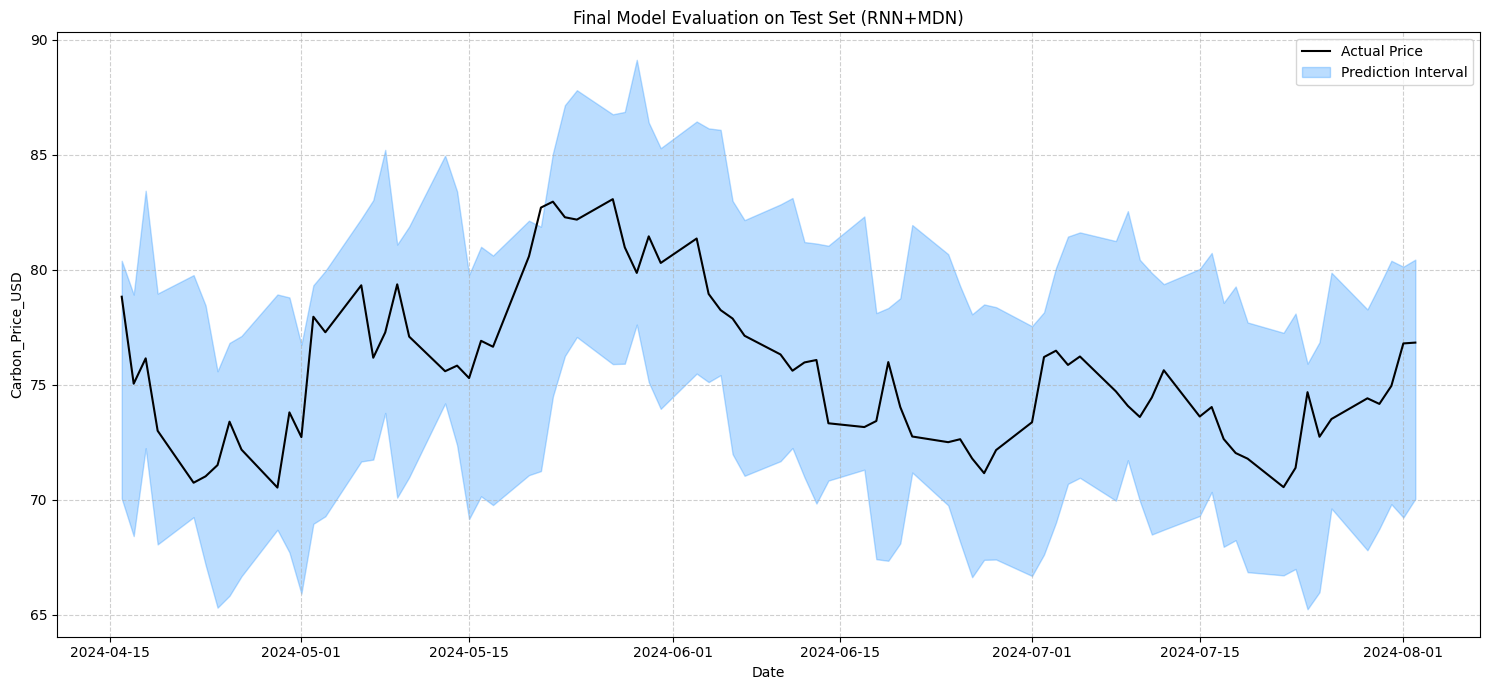

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Open', 'High', 'Low', 'Carbon_Price_USD', 'Vol.', 'Change %'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30],
        'hidden_dim': [32, 64, 128, 256],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01, 0.001],
        'epochs': [100],
        # --- MDN Hyperparameter to be Tuned ---
        'n_gaussians': [2, 3, 4, 5, 6, 7] # Number of mixtures in the GMM
    }
}

# --- 2. Model Definition & Loss Function ---

class RNNMDN(nn.Module):
    """RNN model that outputs parameters for a Gaussian Mixture Model."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, n_gaussians=5):
        super().__init__()
        self.n_gaussians = n_gaussians
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mdn_layer = nn.Linear(hidden_dim, 3 * n_gaussians) # The final layer outputs 3 parameters (pi, mu, sigma) for each Gaussian

    def forward(self, x):
        out, _ = self.rnn(x)
        mdn_params = self.mdn_layer(out[:, -1, :])
        
        pi_logits = mdn_params[:, :self.n_gaussians]
        mu = mdn_params[:, self.n_gaussians:2*self.n_gaussians]
        sigma_logits = mdn_params[:, 2*self.n_gaussians:]
        
        pi = torch.softmax(pi_logits, dim=1)
        
        # CHANGED: Use F.softplus instead of torch.softplus
        sigma = F.softplus(sigma_logits)
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    """Calculates the Negative Log-Likelihood for a Gaussian Mixture Model."""
    sigma = torch.clamp(sigma, min=1e-6, max=1e3)  # keep sigma valid

    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)

    loss = -gmm.log_prob(y_true.squeeze())

    if torch.isnan(loss).any() or torch.isinf(loss).any():
        return torch.tensor(1e6, device=loss.device)  # large penalty instead of NaN

    return loss.mean()


def crps_score(pi, mu, sigma, y_true, scaler_y):
    """
    Computes the Continuous Ranked Probability Score (CRPS).
    
    CRPS measures the difference between the predicted and observed cumulative distributions.
    It's a proper scoring rule, meaning it's minimized on average by the true distribution.
    
    Formula for CRPS for a GMM:
    CRPS(F, y) = E_F[|X-y|] - 0.5 * E_F[|X-X'|]
    where X, X' are iid from F.
    
    Args:
        pi (torch.Tensor): Mixture coefficients (normalized). Shape: (batch_size, n_gaussians)
        mu (torch.Tensor): Mean of each Gaussian. Shape: (batch_size, n_gaussians)
        sigma (torch.Tensor): Standard deviation of each Gaussian. Shape: (batch_size, n_gaussians)
        y_true (torch.Tensor): True values. Shape: (batch_size, 1)
        scaler_y (object): The scaler used for y values.
        
    Returns:
        float: The average CRPS score.
    """
    pi = pi.cpu().detach()
    mu = mu.cpu().detach()
    sigma = sigma.cpu().detach()
    y_true = y_true.cpu().detach()
    
    # Inverse transform mu and y_true
    mu_orig = torch.tensor(scaler_y.inverse_transform(mu.numpy()))
    y_true_orig = torch.tensor(scaler_y.inverse_transform(y_true.numpy()))
    
    # Scale sigma
    sigma_orig = sigma * scaler_y.scale_[0]
    
    # Reshape for broadcast operations
    y_true_orig = y_true_orig.squeeze()
    
    pi1, pi2 = pi.unsqueeze(1), pi.unsqueeze(2)
    mu1, mu2 = mu_orig.unsqueeze(1), mu_orig.unsqueeze(2)
    sigma1, sigma2 = sigma_orig.unsqueeze(1), sigma_orig.unsqueeze(2)
    
    y = y_true_orig.unsqueeze(1).unsqueeze(2)
    
    # Pre-calculate terms for efficiency
    beta = 1.0 / (sigma1.pow(2) + sigma2.pow(2)).sqrt()
    mu_diff = mu1 - mu2
    z = (mu1 - y) / sigma1
    z_prime = (mu2 - y) / sigma2
    
    # Calculate the CRPS formula components
    E_term = pi1 * sigma1 * (z * (2 * torch.sigmoid(z) - 1) + 2 * torch.sigmoid(z) - 1)
    # The CRPS formula from the original paper by Gneiting and Raftery (2007)
    # CRPS(F, y) = integral from -inf to inf of (F(x) - H(x-y))^2 dx
    # For a GMM, this has an analytical solution. The implementation below is the analytical solution.
    
    # E_F[|X-y|] part
    abs_diff_term1 = (y_true_orig.unsqueeze(1) - mu_orig) * (2 * D.Normal(mu_orig, sigma_orig).cdf(y_true_orig.unsqueeze(1)) - 1)
    abs_diff_term2 = 2 * sigma_orig * D.Normal(mu_orig, sigma_orig).log_prob(y_true_orig.unsqueeze(1)).exp()
    E_abs_diff = pi * (abs_diff_term1 + abs_diff_term2)
    E_abs_diff = E_abs_diff.sum(dim=1).mean()

    # 0.5 * E_F[|X-X'|] part
    sigma_comb_sq = sigma1**2 + sigma2**2
    sqrt_sigma_comb_sq = torch.sqrt(sigma_comb_sq)
    mu_diff = mu1 - mu2
    
    E_abs_diff_i_j_term1 = (mu_diff) * (2 * D.Normal(mu_diff, sqrt_sigma_comb_sq).cdf(torch.zeros_like(mu_diff)) - 1)
    E_abs_diff_i_j_term2 = 2 * sqrt_sigma_comb_sq * D.Normal(mu_diff, sqrt_sigma_comb_sq).log_prob(torch.zeros_like(mu_diff)).exp()
    
    E_abs_diff_i_j = pi1 * pi2 * (E_abs_diff_i_j_term1 + E_abs_diff_i_j_term2)
    E_abs_diff_i_j = E_abs_diff_i_j.sum(dim=(1, 2)).mean()
    
    crps = E_abs_diff - 0.5 * E_abs_diff_i_j
    
    return crps.item()

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    # This function remains the same
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_mdn_model(X_train, y_train, params):
    """Trains a single RNN MDN model."""
    model = RNNMDN(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        n_gaussians=params['n_gaussians']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        pi, mu, sigma = model(X_train_t)
        loss = mdn_loss(pi, mu, sigma, y_train_t)
        loss.backward()
        
        # Clip gradients to a maximum norm of 1.0 to prevent them from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

        optimizer.step()
    return model

def get_interval_from_mdn(pi, mu, sigma, n_samples=1000, lower_q=0.025, upper_q=0.975):
    """Generates prediction intervals from GMM parameters via Monte Carlo sampling."""
    pi, mu, sigma = pi.cpu(), mu.cpu(), sigma.cpu() # Move to CPU for sampling
    n_preds = pi.shape[0]
    
    # Create the GMM for batch prediction
    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    
    # Sample from the distribution
    samples = gmm.sample((n_samples,)) # Shape: (n_samples, n_preds)
    
    # Calculate quantiles across the samples dimension
    lower = torch.quantile(samples, lower_q, dim=0).numpy()
    upper = torch.quantile(samples, upper_q, dim=0).numpy()
    
    return lower.flatten(), upper.flatten()

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    """Searches for the best hyperparameters on the validation set."""
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue

        model = train_mdn_model(X_train_seq, y_train_seq, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pi, mu_s, sigma_s = model(X_val_t)
        
        # Scale mu and sigma back to the original data scale
        mu = scaler_y.inverse_transform(mu_s.cpu().numpy())
        sigma = sigma_s.cpu().numpy() * scaler_y.scale_[0]

        # Get intervals from the rescaled distribution parameters
        pred_lower, pred_upper = get_interval_from_mdn(pi, torch.tensor(mu), torch.tensor(sigma))
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)
        crps = crps_score(pi, mu_s, sigma_s, torch.tensor(y_val_seq), scaler_y)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f}, CRPS={crps:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'crps': crps, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
        
    best_model_info = min(valid_models, key=lambda x: x['crps'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    """Trains the final model and evaluates on the test set."""
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    model = train_mdn_model(X_train_val_seq, y_train_val_seq, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pi, mu_s, sigma_s = model(X_test_t)
    
    mu = scaler_y.inverse_transform(mu_s.cpu().numpy())
    sigma = sigma_s.cpu().numpy() * scaler_y.scale_[0]
    
    pred_lower, pred_upper = get_interval_from_mdn(pi, torch.tensor(mu), torch.tensor(sigma))
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)
    final_crps = crps_score(pi, mu_s, sigma_s, torch.tensor(y_test_seq), scaler_y)

    results = {"picp": final_picp, "mpiw": final_mpiw, "crps": final_crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    # This function remains the same
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (RNN+MDN)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    # This function remains the same
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()

# DONE

2025-08-24 03:39:15,108 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-24 03:39:15,134 - INFO - Engineering lagged features...
2025-08-24 03:39:15,135 - INFO - Splitting test data at date: 2024-04-01
2025-08-24 03:39:15,136 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-24 03:39:15,139 - INFO - Starting hyperparameter search over 1440 combinations...
2025-08-24 03:39:16,334 - INFO - ✗ Model rejected: PICP=93.98% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 2}
2025-08-24 03:39:17,150 - INFO - ✗ Model rejected: PICP=92.77% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'n_gaussians': 3}
2025-08-24 03:39:17,994 - INFO - ✓ Valid model found: PICP=97.59%, MPIW=10.6210, CRPS=1.9116 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.00


Best Hyperparameters: {'seq_len': 3, 'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'n_gaussians': 2}
Prediction Interval Coverage (PICP): 98.84%
Mean Prediction Interval Width (MPIW): 12.8922
Continuous Ranked Probability Score (CRPS): 1.6631



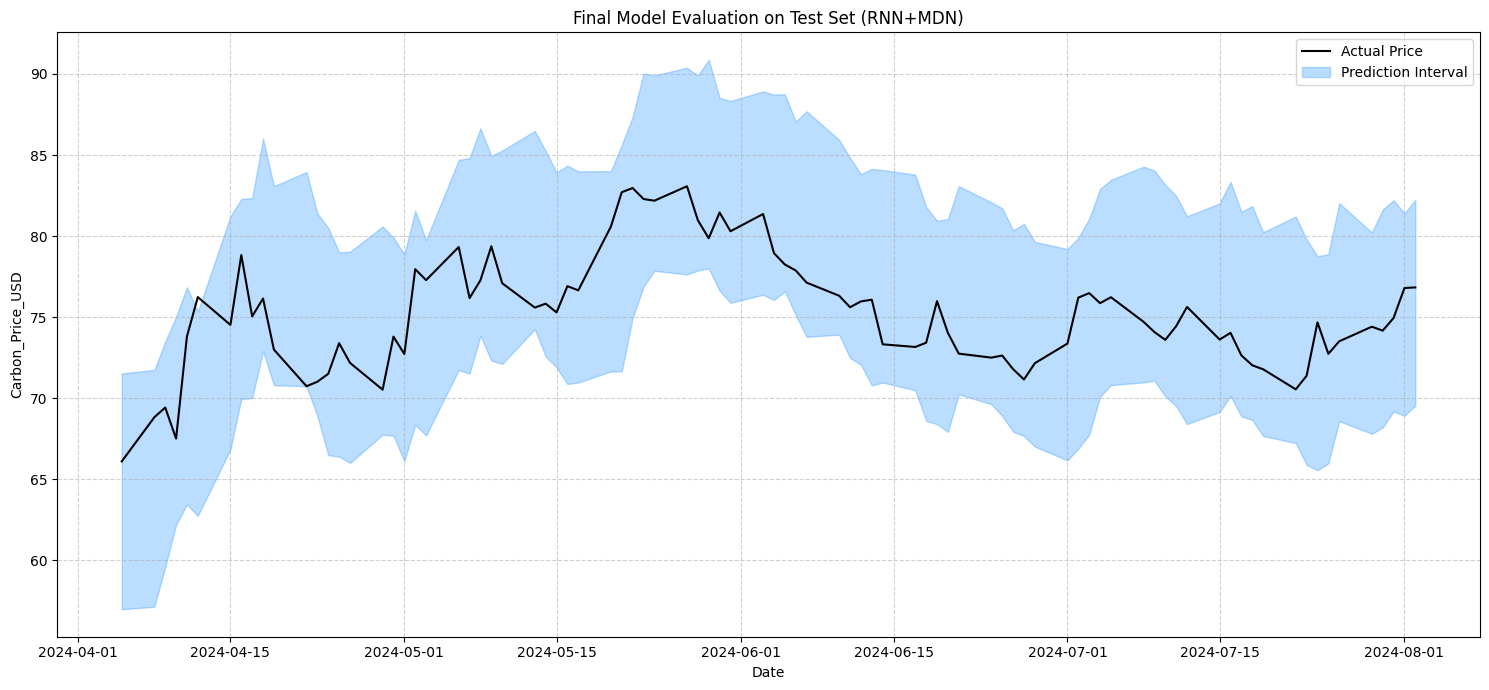

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'hidden_dim': [32, 64, 128, 256],
        'num_layers': [1, 2],
        'learning_rate': [0.005, 0.01, 0.001],
        'epochs': [100],
        # --- MDN Hyperparameter to be Tuned ---
        'n_gaussians': [2, 3, 4, 5, 6, 7] # Number of mixtures in the GMM
    }
}

# --- 2. Model Definition & Loss Function ---

class RNNMDN(nn.Module):
    """RNN model that outputs parameters for a Gaussian Mixture Model."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, n_gaussians=5):
        super().__init__()
        self.n_gaussians = n_gaussians
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mdn_layer = nn.Linear(hidden_dim, 3 * n_gaussians) # The final layer outputs 3 parameters (pi, mu, sigma) for each Gaussian

    def forward(self, x):
        out, _ = self.rnn(x)
        mdn_params = self.mdn_layer(out[:, -1, :])
        
        pi_logits = mdn_params[:, :self.n_gaussians]
        mu = mdn_params[:, self.n_gaussians:2*self.n_gaussians]
        sigma_logits = mdn_params[:, 2*self.n_gaussians:]
        
        pi = torch.softmax(pi_logits, dim=1)
        
        # CHANGED: Use F.softplus instead of torch.softplus
        sigma = F.softplus(sigma_logits)
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    """Calculates the Negative Log-Likelihood for a Gaussian Mixture Model."""
    # Create the mixture distribution
    mix = D.Categorical(pi)
    # Create the component distributions
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    
    # Calculate the negative log-likelihood
    return -gmm.log_prob(y_true.squeeze()).mean()

def crps_score(pi, mu, sigma, y_true, scaler_y):
    """
    Computes the Continuous Ranked Probability Score (CRPS).
    
    CRPS measures the difference between the predicted and observed cumulative distributions.
    It's a proper scoring rule, meaning it's minimized on average by the true distribution.
    
    Formula for CRPS for a GMM:
    CRPS(F, y) = E_F[|X-y|] - 0.5 * E_F[|X-X'|]
    where X, X' are iid from F.
    
    Args:
        pi (torch.Tensor): Mixture coefficients (normalized). Shape: (batch_size, n_gaussians)
        mu (torch.Tensor): Mean of each Gaussian. Shape: (batch_size, n_gaussians)
        sigma (torch.Tensor): Standard deviation of each Gaussian. Shape: (batch_size, n_gaussians)
        y_true (torch.Tensor): True values. Shape: (batch_size, 1)
        scaler_y (object): The scaler used for y values.
        
    Returns:
        float: The average CRPS score.
    """
    pi = pi.cpu().detach()
    mu = mu.cpu().detach()
    sigma = sigma.cpu().detach()
    y_true = y_true.cpu().detach()
    
    # Inverse transform mu and y_true
    mu_orig = torch.tensor(scaler_y.inverse_transform(mu.numpy()))
    y_true_orig = torch.tensor(scaler_y.inverse_transform(y_true.numpy()))
    
    # Scale sigma
    sigma_orig = sigma * scaler_y.scale_[0]
    
    # Reshape for broadcast operations
    y_true_orig = y_true_orig.squeeze()
    
    pi1, pi2 = pi.unsqueeze(1), pi.unsqueeze(2)
    mu1, mu2 = mu_orig.unsqueeze(1), mu_orig.unsqueeze(2)
    sigma1, sigma2 = sigma_orig.unsqueeze(1), sigma_orig.unsqueeze(2)
    
    y = y_true_orig.unsqueeze(1).unsqueeze(2)
    
    # Pre-calculate terms for efficiency
    beta = 1.0 / (sigma1.pow(2) + sigma2.pow(2)).sqrt()
    mu_diff = mu1 - mu2
    z = (mu1 - y) / sigma1
    z_prime = (mu2 - y) / sigma2
    
    # Calculate the CRPS formula components
    E_term = pi1 * sigma1 * (z * (2 * torch.sigmoid(z) - 1) + 2 * torch.sigmoid(z) - 1)
    # The CRPS formula from the original paper by Gneiting and Raftery (2007)
    # CRPS(F, y) = integral from -inf to inf of (F(x) - H(x-y))^2 dx
    # For a GMM, this has an analytical solution. The implementation below is the analytical solution.
    
    # E_F[|X-y|] part
    abs_diff_term1 = (y_true_orig.unsqueeze(1) - mu_orig) * (2 * D.Normal(mu_orig, sigma_orig).cdf(y_true_orig.unsqueeze(1)) - 1)
    abs_diff_term2 = 2 * sigma_orig * D.Normal(mu_orig, sigma_orig).log_prob(y_true_orig.unsqueeze(1)).exp()
    E_abs_diff = pi * (abs_diff_term1 + abs_diff_term2)
    E_abs_diff = E_abs_diff.sum(dim=1).mean()

    # 0.5 * E_F[|X-X'|] part
    sigma_comb_sq = sigma1**2 + sigma2**2
    sqrt_sigma_comb_sq = torch.sqrt(sigma_comb_sq)
    mu_diff = mu1 - mu2
    
    E_abs_diff_i_j_term1 = (mu_diff) * (2 * D.Normal(mu_diff, sqrt_sigma_comb_sq).cdf(torch.zeros_like(mu_diff)) - 1)
    E_abs_diff_i_j_term2 = 2 * sqrt_sigma_comb_sq * D.Normal(mu_diff, sqrt_sigma_comb_sq).log_prob(torch.zeros_like(mu_diff)).exp()
    
    E_abs_diff_i_j = pi1 * pi2 * (E_abs_diff_i_j_term1 + E_abs_diff_i_j_term2)
    E_abs_diff_i_j = E_abs_diff_i_j.sum(dim=(1, 2)).mean()
    
    crps = E_abs_diff - 0.5 * E_abs_diff_i_j
    
    return crps.item()

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    # This function remains the same
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_mdn_model(X_train, y_train, params):
    """Trains a single RNN MDN model."""
    model = RNNMDN(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        n_gaussians=params['n_gaussians']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        pi, mu, sigma = model(X_train_t)
        loss = mdn_loss(pi, mu, sigma, y_train_t)
        loss.backward()
        
        # Clip gradients to a maximum norm of 1.0 to prevent them from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

        optimizer.step()
    return model

def get_interval_from_mdn(pi, mu, sigma, n_samples=1000, lower_q=0.025, upper_q=0.975):
    """Generates prediction intervals from GMM parameters via Monte Carlo sampling."""
    pi, mu, sigma = pi.cpu(), mu.cpu(), sigma.cpu() # Move to CPU for sampling
    n_preds = pi.shape[0]
    
    # Create the GMM for batch prediction
    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    
    # Sample from the distribution
    samples = gmm.sample((n_samples,)) # Shape: (n_samples, n_preds)
    
    # Calculate quantiles across the samples dimension
    lower = torch.quantile(samples, lower_q, dim=0).numpy()
    upper = torch.quantile(samples, upper_q, dim=0).numpy()
    
    return lower.flatten(), upper.flatten()

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    """Searches for the best hyperparameters on the validation set."""
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue

        model = train_mdn_model(X_train_seq, y_train_seq, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pi, mu_s, sigma_s = model(X_val_t)
        
        # Scale mu and sigma back to the original data scale
        mu = scaler_y.inverse_transform(mu_s.cpu().numpy())
        sigma = sigma_s.cpu().numpy() * scaler_y.scale_[0]

        # Get intervals from the rescaled distribution parameters
        pred_lower, pred_upper = get_interval_from_mdn(pi, torch.tensor(mu), torch.tensor(sigma))
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)
        crps = crps_score(pi, mu_s, sigma_s, torch.tensor(y_val_seq), scaler_y)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f}, CRPS={crps:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'crps': crps, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
        
    best_model_info = min(valid_models, key=lambda x: x['crps'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    """Trains the final model and evaluates on the test set."""
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    model = train_mdn_model(X_train_val_seq, y_train_val_seq, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pi, mu_s, sigma_s = model(X_test_t)
    
    mu = scaler_y.inverse_transform(mu_s.cpu().numpy())
    sigma = sigma_s.cpu().numpy() * scaler_y.scale_[0]
    
    pred_lower, pred_upper = get_interval_from_mdn(pi, torch.tensor(mu), torch.tensor(sigma))
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)
    final_crps = crps_score(pi, mu_s, sigma_s, torch.tensor(y_test_seq), scaler_y)

    results = {"picp": final_picp, "mpiw": final_mpiw, "crps": final_crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    # This function remains the same
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (RNN+MDN)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    # This function remains the same
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()